## Investigates the gains for different entropy-coding schemes

In [3]:
import bench_utils
from algos.alg_fpd_extended import FpdExtended
from shapely.geometry import shape
from algos.fpd_extended_lib.compress import get_zz_encoded_delta
from algos.fpd_extended_lib.decompress import decode_header
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
fpde = FpdExtended()
#%pip install dill
import dill as pickle
import math
from intersection.plotting import xs, ys
import numpy as np

ENTROPY_BASE_PATH = "data/entropy_models"

In [4]:
# Load a bunch of data-sets
# chunks[delta_size] - contains a list of chunks, first indexed by the number of bits used per delta


from collections import defaultdict
from bitarray import bitarray
from algos.fpd_extended_lib import cfg
import shapely
import tqdm

shape_cnt = 0
dt_to_coord = defaultdict()
dt_freq = defaultdict(lambda: defaultdict(int))
dt_xs = []
dt_ys = []
chunks = defaultdict(list)
failed = 0

def append_deltas(dataset, is_shp_dir=False):
    global shape_cnt
    global failed
    if not is_shp_dir:
        df, idxs = bench_utils.read_dataset(dataset)
    else:
        df, idxs = bench_utils.load_shp_files(dataset)

    for idx in tqdm.tqdm(idxs):
        shape_cnt += 1
        geom = shape(df.iloc[idx]) if not is_shp_dir else df.iloc[idx].geometry
        if geom.geom_type not in ["LineString", "Polygon", "MultiPolygon"]:
            continue
        try: 
            bin = fpde.compress(geom)[1]
            cfg.offset = 0
            delta_size, type = decode_header(bin)
            chks = fpde.get_chunks(bin, include_ring_start=False)[0]
            # Go though deltas
            for chk in chks:
                chk_dts = []
                for i in range(len(chk) - 1):
                    dt_x = get_zz_encoded_delta(chk[i][0], chk[i + 1][0])
                    dt_y = get_zz_encoded_delta(chk[i][1], chk[i + 1][1])
                    dt_to_coord[dt_x] = chk[i + 1][0] - chk[i][0]
                    dt_to_coord[dt_y] = chk[i + 1][1] - chk[i][1]
                    dt_freq[delta_size][dt_x] += 1
                    dt_freq[delta_size][dt_y] += 1
                    dt_xs.append(dt_x)
                    dt_ys.append(dt_y)
                    chk_dts += [dt_x, dt_y]
                chunks[delta_size].append(chk_dts)
        except:
            print("Failed one geom!")
            #print(geom)
            #return
            failed += 1
                
GENERATE_DATA = False
SAVE_DATA = False
GENERATE_MODELS = False # Set to False to load stored models
SAVE_MODELS = False

if GENERATE_DATA:
    append_deltas("data/sweden-latest-free", is_shp_dir=True)
    #append_deltas("data/lund_building_highway.json")
    #append_deltas("data/world_7_dec.json")
    #append_deltas("data/sweden.json")
    append_deltas("data/final_country_borders.shp")
    append_deltas("data/china-latest-free/gis_osm_water_a_free_1.shp")

    if SAVE_DATA:
        with open('data/delta_freqs.pkl', 'wb') as f:
            pickle.dump([shape_cnt, dt_to_coord, dt_freq, dt_xs, dt_ys, chunks], f)
    print("Failed:", failed)
else:
    with open('data/delta_freqs.pkl', 'rb') as f:
        shape_cnt, dt_to_coord, dt_freq, dt_xs, dt_ys, chunks = pickle.load(f)
    

print(f"Number of shapes: {shape_cnt}")
print(f"Number of deltas: {len(dt_xs) + len(dt_ys)}")

Number of shapes: 7534171
Number of deltas: 216530818


In [5]:
dt_freq_sorted = defaultdict(lambda: defaultdict(int))
dt_freq_sorted_key = defaultdict(lambda: defaultdict(int))
for bit_size in sorted(dt_freq.keys()):
    freqs = sorted(dt_freq[bit_size].items(), key=lambda x: -x[1])
    dt_freq_sorted[bit_size] = freqs
    dt_freq_sorted_key[bit_size] = sorted(dt_freq[bit_size].items(), key=lambda x: x[0])

DISP = 12
print(dt_freq_sorted[DISP])
print(dt_freq_sorted_key[DISP])


# merged_dict = {}
# for _, dictionary in dt_freq_sorted.items():
#     for key, value in dictionary:
#         if key in merged_dict:
#             merged_dict[key] += value
#         else:
#            merged_dict[key] = value

# tot_sum = 0
# for key, value in sorted(merged_dict.items(), key=lambda x: -x[1])[:10]:
#     tot_sum += 100 * value / sum(merged_dict.values())
# print(tot_sum)

# tot_sum = 0
# for key, value in sorted(merged_dict.items(), key=lambda x: -x[1])[10:100]:
#     tot_sum += 100 * value / sum(merged_dict.values())
# print(tot_sum)

[(0, 186017), (858, 43992), (857, 41940), (644, 41677), (322, 39665), (643, 39548), (321, 36512), (536, 34958), (1180, 34366), (1502, 34075), (966, 33758), (1179, 33432), (214, 33395), (535, 33221), (965, 32920), (1501, 32735), (1288, 30696), (213, 30648), (430, 30630), (108, 30440), (54, 29426), (429, 29375), (1287, 29326), (1716, 28699), (107, 28219), (53, 28028), (590, 27829), (912, 26870), (1824, 26842), (1715, 26841), (589, 26663), (1072, 26396), (2146, 26083), (911, 25629), (1823, 25529), (268, 25497), (1071, 25472), (106, 25288), (51, 24926), (752, 24752), (52, 24672), (105, 24576), (428, 24122), (751, 24114), (750, 24027), (267, 23915), (749, 23484), (2145, 23324), (1394, 23265), (376, 23264), (427, 22767), (1393, 22748), (1074, 22353), (1610, 22345), (698, 22226), (375, 21897), (697, 21743), (1073, 21689), (25, 21650), (26, 21586), (1609, 21527), (482, 21197), (481, 20555), (804, 20422), (2360, 20152), (803, 20116), (2038, 19719), (103, 19718), (160, 19445), (216, 19239), (123

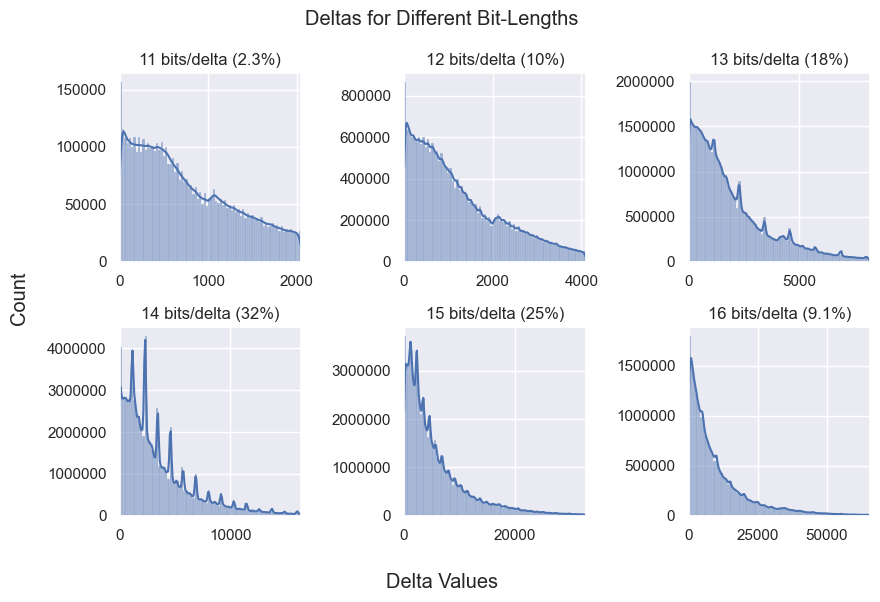

In [17]:
#sns.kdeplot()

HEIGHT = 2
WIDTH = 3

PLOT = False

if PLOT:
    sns.set(font_scale=1)
    tot_dts = len(dt_xs) + len(dt_ys)
    fig, axes = plt.subplots(HEIGHT, WIDTH)
    cnt_plotted = 0
    for idx, bit_size in enumerate(sorted(dt_freq.keys())):
        chks = chunks[bit_size]
        dts = [item for sublist in chks for item in sublist]
        if len(dts)/tot_dts > 0.01 and cnt_plotted < 6:
            curr_height, curr_width = cnt_plotted // WIDTH, cnt_plotted % WIDTH
            current_axis = axes[curr_height, curr_width]
            current_axis.set_title(f"{bit_size} bits/delta ({round(100 * len(dts)/tot_dts, 1 if len(dts)/tot_dts < 0.1 else None)}%)")

            #data = list(dt_freq[bit_size].items())
            #ax = sns.kdeplot(dts, ax=current_axis)
            #ax = sns.scatterplot(x = xs(data), y=ys(data), ax=current_axis, size=0.1)
            ax = sns.histplot(dts, ax=current_axis, bins=80, kde=True)
            ax.ticklabel_format(style='plain', axis='y')
            current_axis.set_xlim(0, max(dts))
            current_axis.set(ylabel=None)
            cnt_plotted += 1
            
    fig.supylabel('Count')
    fig.supxlabel('Delta Values')
    fig.suptitle('Deltas for Different Bit-Lengths')
    fig.set_figwidth(WIDTH * 3)
    fig.set_figheight(HEIGHT * 3)
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.savefig("plots/delta_distrb.png", dpi=1000)
    plt.savefig("plots/delta_distrb.svg")
    plt.show()

In [6]:
# for i in range(1):
#     idx = random.randint(0, len(deltas_fp))
#     print("---")
#     print("Delta in FP and LONG:    ", f'{deltas_fp[idx]:.14f}', '        ', deltas_long[idx])
#     print("Converting to f32:       ", f'{struct.unpack("!f", struct.pack("!f", deltas_fp[idx]))[0]:.14f}')
#     print("Required bits:           ", math.ceil(math.log2(deltas_long[idx] + 1)))
#     bin = util.int2ba(deltas_long[idx], length=64)
#     print("ZZ-encoded:              ", end=None)
#     util.pprint(bin, width=200)

#     bin = bitarray()
#     print("FP directly to bin:      ", end=None)
#     bin.frombytes(struct.pack("!d", deltas_fp[idx]))
#     util.pprint(bin, width=200)

#     bin = bitarray()
#     print("FP32 directly to bin:    ", end=None)
#     bin.frombytes(struct.pack("!f", deltas_fp[idx]))
    
#     util.pprint(bin, width=200)

## Calculate Entropy

In [8]:
total_freq = defaultdict(int)
sum_none_size = 0
sum_opt_size = 0
tot_d_cnt = 0

for idx, bit_size in enumerate(sorted(dt_freq.keys())):
    entropy = 0
    chks = chunks[bit_size]
    freq = dt_freq[bit_size]
    tot = sum(freq.values())
    tot_d_cnt += tot
    sum_none_size += bit_size * tot
    for i in freq:
        total_freq[i] += freq[i]
        p_i = freq[i] / tot
        entropy += - p_i * np.log2(p_i)
    print(bit_size, ": Bits/delta", entropy)
    sum_opt_size += entropy * tot
#road building, one more
entropy = 0
tot = sum(total_freq.values())
for i in total_freq:
    p_i = total_freq[i] / tot
    entropy += - p_i * np.log2(p_i)

none_bit_len = sum_none_size/tot_d_cnt
per_delta_bit_len = sum_opt_size/tot_d_cnt
print("TOT: Bits/delta (one model):", entropy, "(%, factor):", entropy/none_bit_len, none_bit_len/entropy)
print("TOT: Bits/delta (model per delta):", per_delta_bit_len, "(%, factor):", per_delta_bit_len/none_bit_len, none_bit_len/per_delta_bit_len)
print("TOT: Average bits/delta no entropy:", none_bit_len)

2 : Bits/delta 1.0
3 : Bits/delta 2.8256955386264506
4 : Bits/delta 3.849386918871058
5 : Bits/delta 4.731907756637331
6 : Bits/delta 5.824317378788618
7 : Bits/delta 6.780183937170995
8 : Bits/delta 7.739277970699349
9 : Bits/delta 8.711064072321657
10 : Bits/delta 9.789852891817755
11 : Bits/delta 10.773268003604462
12 : Bits/delta 11.503951877684768
13 : Bits/delta 12.01785752565852
14 : Bits/delta 12.172735678132664
15 : Bits/delta 13.258017342282676
16 : Bits/delta 14.268671350152568
17 : Bits/delta 15.036655861109496
18 : Bits/delta 15.749535711824288
19 : Bits/delta 13.69501605543415
20 : Bits/delta 12.886784984278385
21 : Bits/delta 13.34953325079933
22 : Bits/delta 13.515199710773047
23 : Bits/delta 12.09128372408044
24 : Bits/delta 7.572446349946941
TOT: Bits/delta (one model): 12.980225149264106 (%, factor): 0.9212325217312612 1.0855022770154834
TOT: Bits/delta (model per delta): 12.564579149434774 (%, factor): 0.891733294393745 1.121411532222604
TOT: Average bits/delta no e

## Encoding Huffman

In [9]:
def evaluate_encoder(setup, bit_sizes=[]):
    glob_size_coded = 0
    glob_size_normal = 0
    keys = list(filter(lambda x: x != 0, sorted(dt_freq.keys())))
    if len(bit_sizes) != 0:
        keys = list(filter(lambda x: x in bit_sizes, keys))
    for idx, bit_size in enumerate(keys):
        chks = chunks[bit_size]
        dts = [item for sublist in chks for item in sublist]
        dt_freqs = dict(dt_freq_sorted[bit_size])
        get_encoded_size = setup(dt_freqs, chks, dts, bit_size)
        
        size_coded = 0
        size_normal = 0
        for chk in tqdm.tqdm(chks):
            size_coded += get_encoded_size(chk)
            size_normal += len(chk) * bit_size

        print(f"---: {bit_size} : DELTAS {len(dts)} ({len(dts) / len(dt_xs + dt_ys)}) :---")
        print("Deltas present:", len(dt_freqs.keys()) / math.pow(2, bit_size))
        print("Enc:", size_coded)
        print("Nor:", size_normal)
        print("Percentage:", size_coded / size_normal)
        print("Factor:", size_normal / size_coded)
        print("Bit-size:", bit_size * (size_coded / size_normal))
        glob_size_coded += size_coded
        glob_size_normal += size_normal


    print(f"\n---: IN TOTAL :---")
    print("Enc:", glob_size_coded)
    print("Nor:", glob_size_normal)
    print("Percentage:", glob_size_coded / glob_size_normal)
    print("Factor:", glob_size_normal / glob_size_coded)
    print("Bit-size:", glob_size_coded / tot_d_cnt)
    print("Bit-size no coding:", glob_size_normal / tot_d_cnt)

In [11]:
#%pip install dahuffman
from dahuffman import HuffmanCodec
from bitarray import util

'''
    Huffman encoding of deltas. Note that this tree does not support missing deltas, hence the implementation
    below this cell is used in FPDE.
'''
def huff_setup(dt_freqs, chks, dts, bit_size):

    if GENERATE_MODELS:
        codec = util.huffman_code(dt_freqs)
        if SAVE_MODELS:
            with open(f'{ENTROPY_BASE_PATH}/huff_{bit_size}.pkl', 'wb') as f:
                pickle.dump([bit_size, codec], f)
    else:
        with open(f'{ENTROPY_BASE_PATH}/huff_{bit_size}.pkl', 'rb') as f:
            _, codec = pickle.load(f)

    def huff(chk):
        encoded = bitarray()
        encoded.encode(codec, chk)
        USE_TOGGLE_BIT = False
        if USE_TOGGLE_BIT:
            min_size = min(len(encoded), len(chk) * bit_size)
            size = min_size + 1
        else:
            size = len(encoded)
        return size
    return huff

evaluate_encoder(huff_setup)

You should consider upgrading via the 'c:\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


100%|██████████| 1/1 [00:00<?, ?it/s]

---: 2 : DELTAS 2 (9.236560497360704e-09) :---
Deltas present: 0.5
Enc: 2
Nor: 4
Percentage: 0.5
Factor: 2.0
Bit-size: 1.0



100%|██████████| 40/40 [00:00<00:00, 40098.51it/s]


---: 3 : DELTAS 680 (3.140430569102639e-06) :---
Deltas present: 1.0
Enc: 1996
Nor: 2040
Percentage: 0.9784313725490196
Factor: 1.0220440881763526
Bit-size: 2.9352941176470586


100%|██████████| 23/23 [00:00<?, ?it/s]


---: 4 : DELTAS 384 (1.7734196154932552e-06) :---
Deltas present: 0.9375
Enc: 1486
Nor: 1536
Percentage: 0.9674479166666666
Factor: 1.0336473755047106
Bit-size: 3.8697916666666665


100%|██████████| 113/113 [00:00<00:00, 113251.22it/s]


---: 5 : DELTAS 1210 (5.588119100903226e-06) :---
Deltas present: 1.0
Enc: 5771
Nor: 6050
Percentage: 0.9538842975206612
Factor: 1.048345174146595
Bit-size: 4.769421487603306


100%|██████████| 145/145 [00:00<00:00, 145391.84it/s]


---: 6 : DELTAS 2636 (1.2173786735521407e-05) :---
Deltas present: 1.0
Enc: 15445
Nor: 15816
Percentage: 0.976542741527567
Factor: 1.024020718679184
Bit-size: 5.859256449165402


100%|██████████| 889/889 [00:00<00:00, 445754.48it/s]


---: 7 : DELTAS 14998 (6.926496716970792e-05) :---
Deltas present: 1.0
Enc: 102193
Nor: 104986
Percentage: 0.9733964528603813
Factor: 1.0273306390848689
Bit-size: 6.813775170022669


100%|██████████| 4294/4294 [00:00<00:00, 717543.48it/s]


---: 8 : DELTAS 50620 (0.0002337773461881994) :---
Deltas present: 1.0
Enc: 393633
Nor: 404960
Percentage: 0.9720293362307388
Factor: 1.0287755345715426
Bit-size: 7.776234689845911


100%|██████████| 20374/20374 [00:00<00:00, 638427.14it/s]


---: 9 : DELTAS 263420 (0.0012165473831073782) :---
Deltas present: 1.0
Enc: 2302205
Nor: 2370780
Percentage: 0.9710749204903028
Factor: 1.029786661048864
Bit-size: 8.739674284412725


100%|██████████| 108763/108763 [00:00<00:00, 762640.89it/s]


---: 10 : DELTAS 1060302 (0.004896771784236274) :---
Deltas present: 1.0
Enc: 10411013
Nor: 10603020
Percentage: 0.9818912913490685
Factor: 1.0184426818024337
Bit-size: 9.818912913490685


100%|██████████| 601491/601491 [00:00<00:00, 830727.42it/s]


---: 11 : DELTAS 5049120 (0.023318251169216937) :---
Deltas present: 1.0
Enc: 54569647
Nor: 55540320
Percentage: 0.9825230931330609
Factor: 1.0177877822812378
Bit-size: 10.80775402446367


100%|██████████| 2202137/2202137 [00:03<00:00, 608279.85it/s]


---: 12 : DELTAS 21924536 (0.10125365157028132) :---
Deltas present: 1.0
Enc: 252815041
Nor: 263094432
Percentage: 0.9609288918740782
Factor: 1.0406597287856778
Bit-size: 11.531146702488938


100%|██████████| 2770475/2770475 [00:06<00:00, 443757.58it/s]


---: 13 : DELTAS 38837808 (0.17936388158843974) :---
Deltas present: 1.0
Enc: 467873649
Nor: 504891504
Percentage: 0.9266815648377399
Factor: 1.0791193414699018
Bit-size: 12.046860342890618


100%|██████████| 4019246/4019246 [00:10<00:00, 374923.13it/s]


---: 14 : DELTAS 68304916 (0.31545124445057054) :---
Deltas present: 1.0
Enc: 833502550
Nor: 956268824
Percentage: 0.8716194955656109
Factor: 1.1472896201697282
Bit-size: 12.202672937918553


100%|██████████| 3004208/3004208 [00:10<00:00, 289400.30it/s]


---: 15 : DELTAS 54217560 (0.2503918864796419) :---
Deltas present: 1.0
Enc: 720224542
Nor: 813263400
Percentage: 0.8855981247895823
Factor: 1.1291803494249715
Bit-size: 13.283971871843734


100%|██████████| 1064059/1064059 [00:04<00:00, 226478.40it/s]


---: 16 : DELTAS 19715352 (0.09105102073738067) :---
Deltas present: 0.99993896484375
Enc: 281901445
Nor: 315445632
Percentage: 0.8936609558125059
Factor: 1.1189926039577414
Bit-size: 14.298575293000095


100%|██████████| 219208/219208 [00:01<00:00, 207744.73it/s]


---: 17 : DELTAS 4050700 (0.0187072678033295) :---
Deltas present: 0.9191970825195312
Enc: 61019138
Nor: 68861900
Percentage: 0.8861088352194755
Factor: 1.12852954428822
Bit-size: 15.063850198731084


100%|██████████| 37206/37206 [00:00<00:00, 154155.92it/s]


---: 18 : DELTAS 664862 (0.003070519042698116) :---
Deltas present: 0.49346923828125
Enc: 10493014
Nor: 11967516
Percentage: 0.8767913074024718
Factor: 1.1405222560457844
Bit-size: 15.782243533244493


100%|██████████| 14219/14219 [00:00<00:00, 180469.36it/s]


---: 19 : DELTAS 227022 (0.001048451218615911) :---
Deltas present: 0.12281990051269531
Enc: 3114833
Nor: 4313418
Percentage: 0.722126397209823
Factor: 1.3847991208517438
Bit-size: 13.720401546986636


100%|██████████| 85636/85636 [00:00<00:00, 293749.53it/s]


---: 20 : DELTAS 1394766 (0.006441420269330899) :---
Deltas present: 0.08486175537109375
Enc: 18017437
Nor: 27895320
Percentage: 0.6458946160144425
Factor: 1.5482401853271361
Bit-size: 12.91789232028885


100%|██████████| 38976/38976 [00:00<00:00, 283195.08it/s]


---: 21 : DELTAS 627300 (0.002897047199997185) :---
Deltas present: 0.02762126922607422
Enc: 8391673
Nor: 13173300
Percentage: 0.6370213234345229
Factor: 1.5698061638007106
Bit-size: 13.37744779212498


100%|██████████| 7985/7985 [00:00<00:00, 296537.32it/s]


---: 22 : DELTAS 112822 (0.0005210436142166146) :---
Deltas present: 0.006490945816040039
Enc: 1527708
Nor: 2482084
Percentage: 0.6154940767516329
Factor: 1.6247110049826277
Bit-size: 13.540869688535924


100%|██████████| 485/485 [00:00<00:00, 121570.40it/s]


---: 23 : DELTAS 9016 (4.1638414722102055e-05) :---
Deltas present: 0.0007375478744506836
Enc: 109264
Nor: 207368
Percentage: 0.5269086840785464
Factor: 1.8978620588665984
Bit-size: 12.118899733806568


100%|██████████| 36/36 [00:00<00:00, 36097.29it/s]

---: 24 : DELTAS 786 (3.6299682754627567e-06) :---
Deltas present: 2.5331974029541016e-05
Enc: 6000
Nor: 18864
Percentage: 0.31806615776081426
Factor: 3.144
Bit-size: 7.633587786259542

---: IN TOTAL :---
Enc: 2726799685
Nor: 3050933074
Percentage: 0.8937592594992465
Factor: 1.1188695270807911
Bit-size: 12.593125127343304
Bit-size no coding: 14.090063955699831


# Huffman for common values, else encode whole delta

In [12]:
#%pip install dahuffman
from dahuffman import HuffmanCodec
from bitarray import util

def huff_setup(dt_freqs, chks, dts, bit_size):

    if GENERATE_MODELS:
        N = len(dt_freqs.keys())
        dt_freqs_stripped = dict(filter(lambda x: x[1] > 3, dt_freqs.items()))
        # Append outlier symbol
        sum_values = sum(list(dt_freqs_stripped.values()))
        dt_freqs_stripped[-1] = sum_values * (1 - len(dt_freqs_stripped) / N) # Estimate probablity based on outliers above
        codec = util.huffman_code(dt_freqs_stripped)
        if SAVE_MODELS:
            with open(f'{ENTROPY_BASE_PATH}/huff_{bit_size}.pkl', 'wb') as f:
                pickle.dump([bit_size, codec], f)
    else:
        with open(f'{ENTROPY_BASE_PATH}/huff_{bit_size}.pkl', 'rb') as f:
            _, codec = pickle.load(f)

    def huff(chk):
        encoded = bitarray()
        chk_valid = [x if x in codec.keys() else -1 for x in chk]
        outliers = chk_valid.count(-1)
        encoded.encode(codec, chk_valid)
        size = len(encoded)
        return size + outliers * bit_size
    return huff

evaluate_encoder(huff_setup, bit_sizes=[])

100%|██████████| 1/1 [00:00<?, ?it/s]


---: 2 : DELTAS 2 (9.236560497360704e-09) :---
Deltas present: 0.5
Enc: 6
Nor: 4
Percentage: 1.5
Factor: 0.6666666666666666
Bit-size: 3.0


100%|██████████| 40/40 [00:00<00:00, 39974.31it/s]


---: 3 : DELTAS 680 (3.140430569102639e-06) :---
Deltas present: 1.0
Enc: 2002
Nor: 2040
Percentage: 0.9813725490196078
Factor: 1.018981018981019
Bit-size: 2.9441176470588233


100%|██████████| 23/23 [00:00<00:00, 23117.42it/s]

---: 4 : DELTAS 384 (1.7734196154932552e-06) :---


Deltas present: 0.9375
Enc: 1497
Nor: 1536
Percentage: 0.974609375
Factor: 1.0260521042084167
Bit-size: 3.8984375


100%|██████████| 113/113 [00:00<00:00, 113305.37it/s]


---: 5 : DELTAS 1210 (5.588119100903226e-06) :---
Deltas present: 1.0
Enc: 5777
Nor: 6050
Percentage: 0.9548760330578513
Factor: 1.04725636143327
Bit-size: 4.774380165289257


100%|██████████| 145/145 [00:00<00:00, 48417.65it/s]


---: 6 : DELTAS 2636 (1.2173786735521407e-05) :---
Deltas present: 1.0
Enc: 15451
Nor: 15816
Percentage: 0.9769221041982802
Factor: 1.0236230664681898
Bit-size: 5.861532625189681


100%|██████████| 889/889 [00:00<00:00, 111425.30it/s]


---: 7 : DELTAS 14998 (6.926496716970792e-05) :---
Deltas present: 1.0
Enc: 102198
Nor: 104986
Percentage: 0.9734440782580535
Factor: 1.0272803773067967
Bit-size: 6.8141085478063745


100%|██████████| 4294/4294 [00:00<00:00, 358807.48it/s]


---: 8 : DELTAS 50620 (0.0002337773461881994) :---
Deltas present: 1.0
Enc: 393651
Nor: 404960
Percentage: 0.9720737850651916
Factor: 1.0287284930052254
Bit-size: 7.776590280521533


100%|██████████| 20374/20374 [00:00<00:00, 252206.13it/s]


---: 9 : DELTAS 263420 (0.0012165473831073782) :---
Deltas present: 1.0
Enc: 2302282
Nor: 2370780
Percentage: 0.9711073992525666
Factor: 1.0297522197541396
Bit-size: 8.739966593273099


100%|██████████| 108763/108763 [00:00<00:00, 396562.68it/s]


---: 10 : DELTAS 1060302 (0.004896771784236274) :---
Deltas present: 1.0
Enc: 10411271
Nor: 10603020
Percentage: 0.9819156240391889
Factor: 1.0184174439412825
Bit-size: 9.819156240391889


100%|██████████| 601491/601491 [00:01<00:00, 349019.78it/s]


---: 11 : DELTAS 5049120 (0.023318251169216937) :---
Deltas present: 1.0
Enc: 54570235
Nor: 55540320
Percentage: 0.9825336800364132
Factor: 1.0177768155112399
Bit-size: 10.807870480400545


100%|██████████| 2202137/2202137 [00:07<00:00, 293109.96it/s]


---: 12 : DELTAS 21924536 (0.10125365157028132) :---
Deltas present: 1.0
Enc: 252815541
Nor: 263094432
Percentage: 0.9609307923323896
Factor: 1.0406576706453343
Bit-size: 11.531169507988675


100%|██████████| 2770475/2770475 [00:12<00:00, 220697.69it/s]


---: 13 : DELTAS 38837808 (0.17936388158843974) :---
Deltas present: 1.0
Enc: 467873838
Nor: 504891504
Percentage: 0.9266819391755897
Factor: 1.0791189055541934
Bit-size: 12.046865209282666


100%|██████████| 4019246/4019246 [00:21<00:00, 186048.22it/s]


---: 14 : DELTAS 68304916 (0.31545124445057054) :---
Deltas present: 1.0
Enc: 833502650
Nor: 956268824
Percentage: 0.8716196001387158
Factor: 1.147289482522941
Bit-size: 12.202674401942021


100%|██████████| 3004208/3004208 [00:20<00:00, 149619.15it/s]


---: 15 : DELTAS 54217560 (0.2503918864796419) :---
Deltas present: 1.0
Enc: 720224565
Nor: 813263400
Percentage: 0.8855981530707026
Factor: 1.1291803133651794
Bit-size: 13.283972296060538


100%|██████████| 1064059/1064059 [00:08<00:00, 126607.23it/s]


---: 16 : DELTAS 19715352 (0.09105102073738067) :---
Deltas present: 0.99993896484375
Enc: 282011841
Nor: 315445632
Percentage: 0.8940109242026214
Factor: 1.1185545645227004
Bit-size: 14.304174787241942


100%|██████████| 219208/219208 [00:01<00:00, 112428.25it/s]


---: 17 : DELTAS 4050700 (0.0187072678033295) :---
Deltas present: 0.9191970825195312
Enc: 62461603
Nor: 68861900
Percentage: 0.9070560498621153
Factor: 1.10246770323842
Bit-size: 15.41995284765596


100%|██████████| 37206/37206 [00:00<00:00, 127324.32it/s]


---: 18 : DELTAS 664862 (0.003070519042698116) :---
Deltas present: 0.49346923828125
Enc: 10904842
Nor: 11967516
Percentage: 0.9112034611025379
Factor: 1.097449738382271
Bit-size: 16.401662299845682


100%|██████████| 14219/14219 [00:00<00:00, 203675.41it/s]


---: 19 : DELTAS 227022 (0.001048451218615911) :---
Deltas present: 0.12281990051269531
Enc: 3381509
Nor: 4313418
Percentage: 0.7839511496451306
Factor: 1.275589684960176
Bit-size: 14.895071843257481


100%|██████████| 85636/85636 [00:00<00:00, 179635.36it/s]


---: 20 : DELTAS 1394766 (0.006441420269330899) :---
Deltas present: 0.08486175537109375
Enc: 19279756
Nor: 27895320
Percentage: 0.6911466152745335
Factor: 1.4468710081185674
Bit-size: 13.822932305490669


100%|██████████| 38976/38976 [00:00<00:00, 188796.07it/s]


---: 21 : DELTAS 627300 (0.002897047199997185) :---
Deltas present: 0.02762126922607422
Enc: 9059112
Nor: 13173300
Percentage: 0.6876873676299788
Factor: 1.4541491483933524
Bit-size: 14.441434720229555


100%|██████████| 7985/7985 [00:00<00:00, 181962.75it/s]


---: 22 : DELTAS 112822 (0.0005210436142166146) :---
Deltas present: 0.006490945816040039
Enc: 1775239
Nor: 2482084
Percentage: 0.7152211609276721
Factor: 1.3981689226070406
Bit-size: 15.734865540408785


100%|██████████| 485/485 [00:00<00:00, 81051.77it/s]


---: 23 : DELTAS 9016 (4.1638414722102055e-05) :---
Deltas present: 0.0007375478744506836
Enc: 189790
Nor: 207368
Percentage: 0.9152328228077621
Factor: 1.0926181569102693
Bit-size: 21.050354924578528


100%|██████████| 36/36 [00:00<?, ?it/s]

---: 24 : DELTAS 786 (3.6299682754627567e-06) :---
Deltas present: 2.5331974029541016e-05
Enc: 13057
Nor: 18864
Percentage: 0.6921649703138253
Factor: 1.444742283832427
Bit-size: 16.611959287531807

---: IN TOTAL :---
Enc: 2731297713
Nor: 3050933074
Percentage: 0.8952335717476312
Factor: 1.1170269207485695
Bit-size: 12.613898281213716
Bit-size no coding: 14.090063955699831


In [14]:
#%pip install golomb_coding
from golomb_coding import golomb_coding, optimal_golomb_coding
from bitarray import util

golomb_param = {}

def golomb_setup(dt_freqs, chks, dts, bit_size):
    delta_mean = sum(dts) / len(dts)
    golden_ratio = (math.sqrt(5) + 1) / 2
    param = max(0, 1 + math.floor(math.log2(math.log(golden_ratio - 1) / math.log(delta_mean / (delta_mean + 1)))))
    param = int(math.pow(2, param))
    golomb_param[bit_size] = param
    tot = sum(dt_freqs.values())
    def golomb(chk):
        encoded = [golomb_coding(d, param) for d in chk]
        #encoded = [optimal_golomb_coding(d, dt_freqs[d] / tot) for d in chk]
        return sum(list(map(lambda x: len(x), encoded)))
    return golomb

evaluate_encoder(golomb_setup, bit_sizes=[])

You should consider upgrading via the 'c:\Python310\python.exe -m pip install --upgrade pip' command.


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for golomb_coding, since package 'wheel' is not installed.
Using legacy 'setup.py install' for minimal_binary_coding, since package 'wheel' is not installed.
Using legacy 'setup.py install' for unary_coding, since package 'wheel' is not installed.
  Running setup.py install for unary_coding: started
  Running setup.py install for unary_coding: finished with status 'done'
  Running setup.py install for minimal_binary_coding: started
  Running setup.py install for minimal_binary_coding: finished with status 'done'
  Running setup.py install for golomb_coding: started
  Running setup.py install for golomb_coding: finished with status 'done'
Note: you may ne

100%|██████████| 1/1 [00:00<?, ?it/s]


---: 2 : DELTAS 2 (9.236560497360704e-09) :---
Deltas present: 0.5
Enc: 5
Nor: 4
Percentage: 1.25
Factor: 0.8
Bit-size: 2.5


100%|██████████| 40/40 [00:00<00:00, 13368.30it/s]


---: 3 : DELTAS 680 (3.140430569102639e-06) :---
Deltas present: 1.0
Enc: 2147
Nor: 2040
Percentage: 1.052450980392157
Factor: 0.9501630181648812
Bit-size: 3.1573529411764705


100%|██████████| 23/23 [00:00<00:00, 11529.70it/s]


---: 4 : DELTAS 384 (1.7734196154932552e-06) :---
Deltas present: 0.9375
Enc: 1665
Nor: 1536
Percentage: 1.083984375
Factor: 0.9225225225225225
Bit-size: 4.3359375


100%|██████████| 113/113 [00:00<00:00, 18879.71it/s]


---: 5 : DELTAS 1210 (5.588119100903226e-06) :---
Deltas present: 1.0
Enc: 6073
Nor: 6050
Percentage: 1.003801652892562
Factor: 0.9962127449366046
Bit-size: 5.01900826446281


100%|██████████| 145/145 [00:00<00:00, 12116.23it/s]


---: 6 : DELTAS 2636 (1.2173786735521407e-05) :---
Deltas present: 1.0
Enc: 15989
Nor: 15816
Percentage: 1.0109382903388973
Factor: 0.9891800612921383
Bit-size: 6.065629742033384


100%|██████████| 889/889 [00:00<00:00, 37141.03it/s]


---: 7 : DELTAS 14998 (6.926496716970792e-05) :---
Deltas present: 1.0
Enc: 105607
Nor: 104986
Percentage: 1.0059150743908711
Factor: 0.9941197079739033
Bit-size: 7.041405520736098


100%|██████████| 4294/4294 [00:00<00:00, 36487.65it/s]


---: 8 : DELTAS 50620 (0.0002337773461881994) :---
Deltas present: 1.0
Enc: 406001
Nor: 404960
Percentage: 1.002570624259186
Factor: 0.9974359669064855
Bit-size: 8.020564994073489


100%|██████████| 20374/20374 [00:00<00:00, 49226.08it/s]


---: 9 : DELTAS 263420 (0.0012165473831073782) :---
Deltas present: 1.0
Enc: 2335020
Nor: 2370780
Percentage: 0.9849163566421177
Factor: 1.0153146439859186
Bit-size: 8.864247209779059


100%|██████████| 108763/108763 [00:01<00:00, 61474.18it/s]


---: 10 : DELTAS 1060302 (0.004896771784236274) :---
Deltas present: 1.0
Enc: 10563366
Nor: 10603020
Percentage: 0.9962601221161518
Factor: 1.0037539170752958
Bit-size: 9.962601221161517


100%|██████████| 601491/601491 [00:09<00:00, 66700.53it/s]


---: 11 : DELTAS 5049120 (0.023318251169216937) :---
Deltas present: 1.0
Enc: 55590278
Nor: 55540320
Percentage: 1.0008994906763231
Factor: 0.9991013176800447
Bit-size: 11.009894397439554


100%|██████████| 2202137/2202137 [00:42<00:00, 52267.72it/s]


---: 12 : DELTAS 21924536 (0.10125365157028132) :---
Deltas present: 1.0
Enc: 257954504
Nor: 263094432
Percentage: 0.9804635622239242
Factor: 1.0199257152726435
Bit-size: 11.76556274668709


100%|██████████| 2770475/2770475 [01:12<00:00, 38153.53it/s]


---: 13 : DELTAS 38837808 (0.17936388158843974) :---
Deltas present: 1.0
Enc: 482529323
Nor: 504891504
Percentage: 0.9557089378156777
Factor: 1.0463436726725104
Bit-size: 12.42421619160381


100%|██████████| 4019246/4019246 [02:09<00:00, 31031.57it/s]


---: 14 : DELTAS 68304916 (0.31545124445057054) :---
Deltas present: 1.0
Enc: 903036075
Nor: 956268824
Percentage: 0.9443328615719883
Factor: 1.0589486405623385
Bit-size: 13.220660062007836


100%|██████████| 3004208/3004208 [01:41<00:00, 29710.08it/s]


---: 15 : DELTAS 54217560 (0.2503918864796419) :---
Deltas present: 1.0
Enc: 757239843
Nor: 813263400
Percentage: 0.931112654276585
Factor: 1.0739839002370086
Bit-size: 13.966689814148774


100%|██████████| 1064059/1064059 [00:37<00:00, 28415.48it/s]


---: 16 : DELTAS 19715352 (0.09105102073738067) :---
Deltas present: 0.99993896484375
Enc: 292923755
Nor: 315445632
Percentage: 0.9286029834770386
Factor: 1.076886481944764
Bit-size: 14.857647735632618


100%|██████████| 219208/219208 [00:07<00:00, 28746.65it/s]


---: 17 : DELTAS 4050700 (0.0187072678033295) :---
Deltas present: 0.9191970825195312
Enc: 63944681
Nor: 68861900
Percentage: 0.9285930391116133
Factor: 1.076898014394661
Bit-size: 15.786081664897425


100%|██████████| 37206/37206 [00:01<00:00, 28586.98it/s]


---: 18 : DELTAS 664862 (0.003070519042698116) :---
Deltas present: 0.49346923828125
Enc: 11153078
Nor: 11967516
Percentage: 0.9319459443379896
Factor: 1.0730236083707116
Bit-size: 16.775026998083813


100%|██████████| 14219/14219 [00:00<00:00, 34521.15it/s]


---: 19 : DELTAS 227022 (0.001048451218615911) :---
Deltas present: 0.12281990051269531
Enc: 4090587
Nor: 4313418
Percentage: 0.9483400403114189
Factor: 1.0544740889266015
Bit-size: 18.01846076591696


100%|██████████| 85636/85636 [00:02<00:00, 33152.93it/s]


---: 20 : DELTAS 1394766 (0.006441420269330899) :---
Deltas present: 0.08486175537109375
Enc: 26698788
Nor: 27895320
Percentage: 0.9571063533237834
Factor: 1.044815966927038
Bit-size: 19.142127066475666


100%|██████████| 38976/38976 [00:01<00:00, 33953.72it/s]


---: 21 : DELTAS 627300 (0.002897047199997185) :---
Deltas present: 0.02762126922607422
Enc: 12460132
Nor: 13173300
Percentage: 0.9458626160491297
Factor: 1.0572359907583644
Bit-size: 19.863114937031725


100%|██████████| 7985/7985 [00:00<00:00, 32284.09it/s]


---: 22 : DELTAS 112822 (0.0005210436142166146) :---
Deltas present: 0.006490945816040039
Enc: 2341847
Nor: 2482084
Percentage: 0.9435003005538894
Factor: 1.059883075196629
Bit-size: 20.757006612185567


100%|██████████| 485/485 [00:00<00:00, 21143.94it/s]


---: 23 : DELTAS 9016 (4.1638414722102055e-05) :---
Deltas present: 0.0007375478744506836
Enc: 195758
Nor: 207368
Percentage: 0.9440125766752826
Factor: 1.0593079210045055
Bit-size: 21.7122892635315


100%|██████████| 36/36 [00:00<00:00, 9024.32it/s]

---: 24 : DELTAS 786 (3.6299682754627567e-06) :---
Deltas present: 2.5331974029541016e-05
Enc: 18027
Nor: 18864
Percentage: 0.9556297709923665
Factor: 1.0464303544682976
Bit-size: 22.935114503816795

---: IN TOTAL :---
Enc: 2883612549
Nor: 3050933074
Percentage: 0.9451575891893852
Factor: 1.0580246209075572
Bit-size: 13.317330879893504
Bit-size no coding: 14.090063955699831


In [15]:
#inverted_unary(n // b)+minimal_binary_coding(n % b, b)

from minimal_binary_coding import minimal_binary_coding
from unary_coding import inverted_unary


def golomb_huff_setup(dt_freqs, chks, dts, bit_size):
    delta_mean = sum(dts) / len(dts)
    golden_ratio = (math.sqrt(5) + 1) / 2
    param = max(0, 1 + math.floor(math.log2(math.log(golden_ratio - 1) / math.log(delta_mean / (delta_mean + 1)))))
    param = int(math.pow(2, param))
    k_freqs = defaultdict(int)

    #k_freq_dist = []
    for d, cnt in dt_freqs.items():
        k = inverted_unary(d // param)
        k_freqs[k] += cnt
        #k_freq_dist += [k for _ in range(cnt)]
    
    #sns.histplot(k_freq_dist, bins=40)
    k_codec = util.huffman_code(k_freqs)

    def golomb_huff(chk):
        enc_len = 0
        for d in chk:
            k = inverted_unary(d // param)
            r = minimal_binary_coding(d % param, param)
            enc_len += len(k_codec[k].to01()) + len(r)

        return enc_len
    return golomb_huff

evaluate_encoder(golomb_huff_setup, bit_sizes=[])

100%|██████████| 1/1 [00:00<00:00, 1004.62it/s]


---: 2 : DELTAS 2 (9.236560497360704e-09) :---
Deltas present: 0.5
Enc: 2
Nor: 4
Percentage: 0.5
Factor: 2.0
Bit-size: 1.0


100%|██████████| 40/40 [00:00<00:00, 10026.42it/s]


---: 3 : DELTAS 680 (3.140430569102639e-06) :---
Deltas present: 1.0
Enc: 2040
Nor: 2040
Percentage: 1.0
Factor: 1.0
Bit-size: 3.0


100%|██████████| 23/23 [00:00<00:00, 11510.44it/s]


---: 4 : DELTAS 384 (1.7734196154932552e-06) :---
Deltas present: 0.9375
Enc: 1536
Nor: 1536
Percentage: 1.0
Factor: 1.0
Bit-size: 4.0


100%|██████████| 113/113 [00:00<00:00, 18884.23it/s]


---: 5 : DELTAS 1210 (5.588119100903226e-06) :---
Deltas present: 1.0
Enc: 5957
Nor: 6050
Percentage: 0.9846280991735538
Factor: 1.0156118851771025
Bit-size: 4.923140495867769


100%|██████████| 145/145 [00:00<00:00, 18175.07it/s]


---: 6 : DELTAS 2636 (1.2173786735521407e-05) :---
Deltas present: 1.0
Enc: 15599
Nor: 15816
Percentage: 0.9862797167425392
Factor: 1.0139111481505225
Bit-size: 5.917678300455235


100%|██████████| 889/889 [00:00<00:00, 19984.65it/s]


---: 7 : DELTAS 14998 (6.926496716970792e-05) :---
Deltas present: 1.0
Enc: 103372
Nor: 104986
Percentage: 0.9846265216314556
Factor: 1.0156135123631158
Bit-size: 6.892385651420189


100%|██████████| 4294/4294 [00:00<00:00, 38788.14it/s]


---: 8 : DELTAS 50620 (0.0002337773461881994) :---
Deltas present: 1.0
Enc: 400362
Nor: 404960
Percentage: 0.9886457921770051
Factor: 1.0114846064311798
Bit-size: 7.909166337416041


100%|██████████| 20374/20374 [00:00<00:00, 42471.48it/s]


---: 9 : DELTAS 263420 (0.0012165473831073782) :---
Deltas present: 1.0
Enc: 2314975
Nor: 2370780
Percentage: 0.9764613334008216
Factor: 1.0241060918584435
Bit-size: 8.788152000607395


100%|██████████| 108763/108763 [00:01<00:00, 56156.15it/s]


---: 10 : DELTAS 1060302 (0.004896771784236274) :---
Deltas present: 1.0
Enc: 10442683
Nor: 10603020
Percentage: 0.9848781762177191
Factor: 1.0153540043301132
Bit-size: 9.848781762177191


100%|██████████| 601491/601491 [00:09<00:00, 66043.32it/s]


---: 11 : DELTAS 5049120 (0.023318251169216937) :---
Deltas present: 1.0
Enc: 54987023
Nor: 55540320
Percentage: 0.9900379219997292
Factor: 1.0100623196131204
Bit-size: 10.890417141997021


100%|██████████| 2202137/2202137 [00:40<00:00, 54320.95it/s]


---: 12 : DELTAS 21924536 (0.10125365157028132) :---
Deltas present: 1.0
Enc: 256464689
Nor: 263094432
Percentage: 0.9748008996252722
Factor: 1.0258505099702049
Bit-size: 11.697610795503266


100%|██████████| 2770475/2770475 [01:11<00:00, 38897.76it/s]


---: 13 : DELTAS 38837808 (0.17936388158843974) :---
Deltas present: 1.0
Enc: 482060256
Nor: 504891504
Percentage: 0.9547798926717531
Factor: 1.047361813623565
Bit-size: 12.41213860473279


100%|██████████| 4019246/4019246 [02:05<00:00, 31941.19it/s]


---: 14 : DELTAS 68304916 (0.31545124445057054) :---
Deltas present: 1.0
Enc: 902408277
Nor: 956268824
Percentage: 0.943676353711182
Factor: 1.0596853424029486
Bit-size: 13.211468951956547


100%|██████████| 3004208/3004208 [01:35<00:00, 31387.40it/s]


---: 15 : DELTAS 54217560 (0.2503918864796419) :---
Deltas present: 1.0
Enc: 756890109
Nor: 813263400
Percentage: 0.9306826164807122
Factor: 1.0744801528381447
Bit-size: 13.960239247210682


100%|██████████| 1064059/1064059 [00:35<00:00, 29651.02it/s]


---: 16 : DELTAS 19715352 (0.09105102073738067) :---
Deltas present: 0.99993896484375
Enc: 292815775
Nor: 315445632
Percentage: 0.9282606740929606
Factor: 1.0772835992186556
Bit-size: 14.85217078548737


100%|██████████| 219208/219208 [00:07<00:00, 30365.90it/s]


---: 17 : DELTAS 4050700 (0.0187072678033295) :---
Deltas present: 0.9191970825195312
Enc: 63922384
Nor: 68861900
Percentage: 0.9282692461288463
Factor: 1.0772736511203962
Bit-size: 15.780577184190387


100%|██████████| 37206/37206 [00:01<00:00, 29568.18it/s]


---: 18 : DELTAS 664862 (0.003070519042698116) :---
Deltas present: 0.49346923828125
Enc: 11149344
Nor: 11967516
Percentage: 0.9316339330567848
Factor: 1.0733829721282258
Bit-size: 16.769410795022125


100%|██████████| 14219/14219 [00:00<00:00, 33045.43it/s]


---: 19 : DELTAS 227022 (0.001048451218615911) :---
Deltas present: 0.12281990051269531
Enc: 4088563
Nor: 4313418
Percentage: 0.9478708068636056
Factor: 1.0549960952050879
Bit-size: 18.009545330408507


100%|██████████| 85636/85636 [00:02<00:00, 32089.40it/s]


---: 20 : DELTAS 1394766 (0.006441420269330899) :---
Deltas present: 0.08486175537109375
Enc: 26698649
Nor: 27895320
Percentage: 0.9571013704090865
Factor: 1.0448214065063741
Bit-size: 19.14202740818173


100%|██████████| 38976/38976 [00:01<00:00, 31932.03it/s]


---: 21 : DELTAS 627300 (0.002897047199997185) :---
Deltas present: 0.02762126922607422
Enc: 12460000
Nor: 13173300
Percentage: 0.9458525957808598
Factor: 1.057247191011236
Bit-size: 19.862904511398057


100%|██████████| 7985/7985 [00:00<00:00, 33222.38it/s]


---: 22 : DELTAS 112822 (0.0005210436142166146) :---
Deltas present: 0.006490945816040039
Enc: 2341843
Nor: 2482084
Percentage: 0.9434986890048846
Factor: 1.0598848855367333
Bit-size: 20.75697115810746


100%|██████████| 485/485 [00:00<00:00, 28602.49it/s]

---: 23 : DELTAS 9016 (4.1638414722102055e-05) :---


Deltas present: 0.0007375478744506836
Enc: 195591
Nor: 207368
Percentage: 0.943207245090853
Factor: 1.060212381960315
Bit-size: 21.693766637089617


100%|██████████| 36/36 [00:00<00:00, 7222.91it/s]


---: 24 : DELTAS 786 (3.6299682754627567e-06) :---
Deltas present: 2.5331974029541016e-05
Enc: 18021
Nor: 18864
Percentage: 0.9553117048346056
Factor: 1.046778758115532
Bit-size: 22.927480916030532

---: IN TOTAL :---
Enc: 2879787050
Nor: 3050933074
Percentage: 0.943903710816044
Factor: 1.0594300970969364
Bit-size: 13.299663653420456
Bit-size no coding: 14.090063955699831


In [16]:
from bitarray import bitarray, util

def fpzip_setup(dt_freqs, chks, dts, bit_size):
    k_freqs = defaultdict(int)
    r_freqs = defaultdict(int)
    for d, cnt in dt_freqs.items():
        k = int(math.floor(np.log2(d))) if d != 0 else -1
        k_freqs[k] += cnt
        #if k != -1:
            #r = d - int(math.pow(2, k))
            #r_freqs[r] += 1
    #k_codec = HuffmanCodec.from_frequencies(k_freqs)
    #r_codec = HuffmanCodec.from_frequencies(r_freqs)
    k_codec = util.huffman_code(k_freqs)
    #r_codec = util.huffman_code(r_freqs)

    def fpzip(chk):
        size = 0
        for d in chk:
            k = int(math.floor(np.log2(d))) if d != 0 else -1
            r = d - int(math.pow(2, k))
            #size += len(k_codec.encode([k])) + (len(r_codec.encode([r])) if k != -1 else 0)
            #size += len(k_codec[k].to01()) + (len(r_codec[r].to01()) if k != -1 else 0)
            size += len(k_codec[k].to01()) + k if k != -1 else 0
        return size 
    return fpzip

evaluate_encoder(fpzip_setup)

100%|██████████| 1/1 [00:00<00:00, 1004.62it/s]


---: 2 : DELTAS 2 (9.236560497360704e-09) :---
Deltas present: 0.5
Enc: 2
Nor: 4
Percentage: 0.5
Factor: 2.0
Bit-size: 1.0


100%|██████████| 40/40 [00:00<00:00, 10027.62it/s]


---: 3 : DELTAS 680 (3.140430569102639e-06) :---
Deltas present: 1.0
Enc: 1749
Nor: 2040
Percentage: 0.8573529411764705
Factor: 1.1663807890222984
Bit-size: 2.5720588235294115


100%|██████████| 23/23 [00:00<00:00, 11529.70it/s]


---: 4 : DELTAS 384 (1.7734196154932552e-06) :---
Deltas present: 0.9375
Enc: 1432
Nor: 1536
Percentage: 0.9322916666666666
Factor: 1.0726256983240223
Bit-size: 3.7291666666666665


100%|██████████| 113/113 [00:00<00:00, 16188.14it/s]


---: 5 : DELTAS 1210 (5.588119100903226e-06) :---
Deltas present: 1.0
Enc: 5687
Nor: 6050
Percentage: 0.94
Factor: 1.0638297872340425
Bit-size: 4.699999999999999


100%|██████████| 145/145 [00:00<00:00, 18175.07it/s]


---: 6 : DELTAS 2636 (1.2173786735521407e-05) :---
Deltas present: 1.0
Enc: 15293
Nor: 15816
Percentage: 0.9669322205361659
Factor: 1.0341986529784868
Bit-size: 5.801593323216995


100%|██████████| 889/889 [00:00<00:00, 28756.47it/s]


---: 7 : DELTAS 14998 (6.926496716970792e-05) :---
Deltas present: 1.0
Enc: 102273
Nor: 104986
Percentage: 0.9741584592231345
Factor: 1.0265270403723368
Bit-size: 6.819109214561942


100%|██████████| 4294/4294 [00:00<00:00, 44386.79it/s]


---: 8 : DELTAS 50620 (0.0002337773461881994) :---
Deltas present: 1.0
Enc: 393259
Nor: 404960
Percentage: 0.9711057882259976
Factor: 1.0297539280728476
Bit-size: 7.768846305807981


100%|██████████| 20374/20374 [00:00<00:00, 40135.11it/s]


---: 9 : DELTAS 263420 (0.0012165473831073782) :---
Deltas present: 1.0
Enc: 2297333
Nor: 2370780
Percentage: 0.9690199006234235
Factor: 1.031970550198861
Bit-size: 8.721179105610812


100%|██████████| 108763/108763 [00:01<00:00, 55754.27it/s]


---: 10 : DELTAS 1060302 (0.004896771784236274) :---
Deltas present: 1.0
Enc: 10372890
Nor: 10603020
Percentage: 0.9782958062891516
Factor: 1.0221857168060202
Bit-size: 9.782958062891517


100%|██████████| 601491/601491 [00:09<00:00, 63983.96it/s]


---: 11 : DELTAS 5049120 (0.023318251169216937) :---
Deltas present: 1.0
Enc: 54635545
Nor: 55540320
Percentage: 0.9837095825159091
Factor: 1.0165601898910315
Bit-size: 10.820805407675


100%|██████████| 2202137/2202137 [00:41<00:00, 53245.49it/s]


---: 12 : DELTAS 21924536 (0.10125365157028132) :---
Deltas present: 1.0
Enc: 254600592
Nor: 263094432
Percentage: 0.9677156223511412
Factor: 1.0333614306756993
Bit-size: 11.612587468213693


100%|██████████| 2770475/2770475 [01:12<00:00, 38036.96it/s]


---: 13 : DELTAS 38837808 (0.17936388158843974) :---
Deltas present: 1.0
Enc: 476846670
Nor: 504891504
Percentage: 0.9444537414913601
Factor: 1.0588131065275133
Bit-size: 12.277898639387681


100%|██████████| 4019246/4019246 [02:05<00:00, 32054.52it/s]


---: 14 : DELTAS 68304916 (0.31545124445057054) :---
Deltas present: 1.0
Enc: 889518424
Nor: 956268824
Percentage: 0.9301970342180683
Factor: 1.0750410538995199
Bit-size: 13.022758479052957


100%|██████████| 3004208/3004208 [01:41<00:00, 29708.31it/s]


---: 15 : DELTAS 54217560 (0.2503918864796419) :---
Deltas present: 1.0
Enc: 750936323
Nor: 813263400
Percentage: 0.9233617583183996
Factor: 1.0829991506483567
Bit-size: 13.850426374775994


100%|██████████| 1064059/1064059 [00:39<00:00, 26752.65it/s]


---: 16 : DELTAS 19715352 (0.09105102073738067) :---
Deltas present: 0.99993896484375
Enc: 290819947
Nor: 315445632
Percentage: 0.9219336630408628
Factor: 1.0846767398661274
Bit-size: 14.750938608653804


100%|██████████| 219208/219208 [00:08<00:00, 26118.93it/s]


---: 17 : DELTAS 4050700 (0.0187072678033295) :---
Deltas present: 0.9191970825195312
Enc: 63294327
Nor: 68861900
Percentage: 0.919148716489089
Factor: 1.0879632229915328
Bit-size: 15.625528180314513


100%|██████████| 37206/37206 [00:01<00:00, 26838.47it/s]


---: 18 : DELTAS 664862 (0.003070519042698116) :---
Deltas present: 0.49346923828125
Enc: 10993502
Nor: 11967516
Percentage: 0.918611848941752
Factor: 1.0885990651568536
Bit-size: 16.535013280951535


100%|██████████| 14219/14219 [00:00<00:00, 31508.08it/s]


---: 19 : DELTAS 227022 (0.001048451218615911) :---
Deltas present: 0.12281990051269531
Enc: 4054883
Nor: 4313418
Percentage: 0.9400626139177793
Factor: 1.0637589296657881
Bit-size: 17.86118966443781


100%|██████████| 85636/85636 [00:02<00:00, 31857.71it/s]


---: 20 : DELTAS 1394766 (0.006441420269330899) :---
Deltas present: 0.08486175537109375
Enc: 26601659
Nor: 27895320
Percentage: 0.9536244430965481
Factor: 1.0486308391517987
Bit-size: 19.072488861930964


100%|██████████| 38976/38976 [00:01<00:00, 25709.15it/s]


---: 21 : DELTAS 627300 (0.002897047199997185) :---
Deltas present: 0.02762126922607422
Enc: 12396301
Nor: 13173300
Percentage: 0.941017133140519
Factor: 1.0626799074982125
Bit-size: 19.7613597959509


100%|██████████| 7985/7985 [00:00<00:00, 36559.24it/s]


---: 22 : DELTAS 112822 (0.0005210436142166146) :---
Deltas present: 0.006490945816040039
Enc: 2310046
Nor: 2482084
Percentage: 0.9306880830785743
Factor: 1.0744738416464434
Bit-size: 20.475137827728634


100%|██████████| 485/485 [00:00<00:00, 22104.07it/s]

---: 23 : DELTAS 9016 (4.1638414722102055e-05) :---


Deltas present: 0.0007375478744506836
Enc: 186182
Nor: 207368
Percentage: 0.8978338027082289
Factor: 1.1137918810626162
Bit-size: 20.650177462289264


100%|██████████| 36/36 [00:00<00:00, 9025.94it/s]

---: 24 : DELTAS 786 (3.6299682754627567e-06) :---
Deltas present: 2.5331974029541016e-05
Enc: 15080
Nor: 18864
Percentage: 0.7994062765055131
Factor: 1.2509283819628647
Bit-size: 19.185750636132315

---: IN TOTAL :---
Enc: 2850399399
Nor: 3050933074
Percentage: 0.9342713621911458
Factor: 1.0703528337363364
Bit-size: 13.163943245252046
Bit-size no coding: 14.090063955699831
